In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models

In [ ]:
model_dir = 'drive/MyDrive/Colab Notebooks/ml_project/Adam_2_batch_64_best.pth'

In [ ]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# https://www.kaggle.com/code/romanrybalko/pretrained-resnet-with-grayscale-images

def grayscale_fix_model(model):
    #w = model.conv1.weight.data.sum(axis=1).reshape(64, 1, 7, 7)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    #model.conv1.weight.data = w
    return model

resnet50_model = grayscale_fix_model(resnet50)


In [ ]:
class MyResNet50(nn.Module):
    def __init__(self, pretrained_model):
        super(MyResNet50, self).__init__()
        self.backbone = pretrained_model

        self.dropout = nn.Dropout(0.3)
        self.extra_layer = nn.Linear(1000, 5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        x = self.softmax(self.extra_layer(x))
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
myresnet50 = MyResNet50(resnet50_model)
myresnet50.to(device)
print(myresnet50)

MyResNet50(
  (backbone): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
model_state_dict = torch.load(model_dir)
myresnet50.load_state_dict(model_state_dict)

<All keys matched successfully>

In [ ]:
import os
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
import numpy as np

# 데이터 변환 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 데이터 경로
data_dir = 'drive/MyDrive/Colab Notebooks/ml_project/ml_validation'

# 새로운 클래스 순서 정의
new_class_order = ['boring', 'call', 'normal', 'sleep', 'smoke']
new_class_to_idx = {cls_name: i for i, cls_name in enumerate(new_class_order)}

# 커스텀 ImageFolder 클래스 정의
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform)
        # 클래스 인덱스 재정의
        self.class_to_idx = new_class_to_idx
        self.classes = new_class_order

        # 샘플의 타겟 인덱스를 새로운 인덱스로 업데이트
        self.samples = [(path, self.class_to_idx[self.classes[target]]) for path, target in self.samples]
        self.targets = [s[1] for s in self.samples]

# CustomImageFolder로 데이터셋 불러오기
dataset = CustomImageFolder(root=data_dir, transform=transform)

# 클래스별 인덱스 확인
class_to_idx = dataset.class_to_idx
print(f'클래스별 인덱스: {class_to_idx}')

# 클래스별 샘플을 줄이는 함수 (normal과 sleep 클래스 추가로 줄이기)
def reduce_class_samples(dataset, reduction_factor=0.5, extra_reduction_factors={}):
    indices_per_class = {class_name: [] for class_name in dataset.classes}

    for idx, (_, target) in enumerate(dataset.samples):
        for class_name, class_idx in dataset.class_to_idx.items():
            if target == class_idx:
                indices_per_class[class_name].append(idx)

    reduced_indices = []
    for class_name, indices in indices_per_class.items():
        np.random.shuffle(indices)  # Shuffle indices before reducing to ensure randomness
        current_reduction_factor = extra_reduction_factors.get(class_name, reduction_factor)
        reduced_count = max(1, int(len(indices) * current_reduction_factor))  # Ensure at least one sample per class
        reduced_indices.extend(indices[:reduced_count])

    return Subset(dataset, reduced_indices)

# 데이터셋 크기를 줄이기 (normal과 sleep 클래스는 더 많이 줄이기)
extra_reduction_factors = {
    'normal': 0.1,
    'sleep': 0.15,
    'call' : 0.3
}
reduced_dataset = reduce_class_samples(dataset, reduction_factor=0.4, extra_reduction_factors=extra_reduction_factors)

# 클래스별 인덱스 확인 (확인용)
reduced_class_counts = [0] * len(dataset.classes)
for idx in reduced_dataset.indices:
    label = dataset.samples[idx][1]
    reduced_class_counts[label] += 1

print(f"데이터셋 크기: {len(reduced_dataset)}")
print("클래스들:", dataset.classes)
print("클래스별 샘플 수:", reduced_class_counts)


클래스별 인덱스: {'boring': 0, 'call': 1, 'normal': 2, 'sleep': 3, 'smoke': 4}
데이터셋 크기: 2498
클래스들: ['boring', 'call', 'normal', 'sleep', 'smoke']
클래스별 샘플 수: [578, 433, 553, 433, 501]


In [ ]:
test_loader = DataLoader(reduced_dataset, batch_size=32, shuffle=False, num_workers=8)
#test_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=8)

Sample data shape: torch.Size([1, 224, 224])


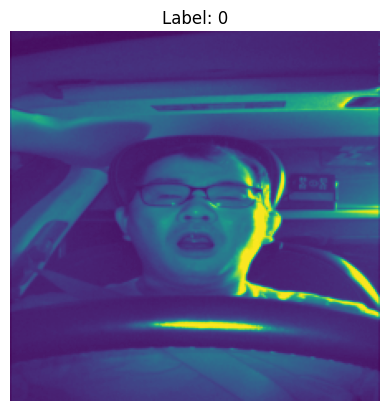

Sample data shape: torch.Size([1, 224, 224])


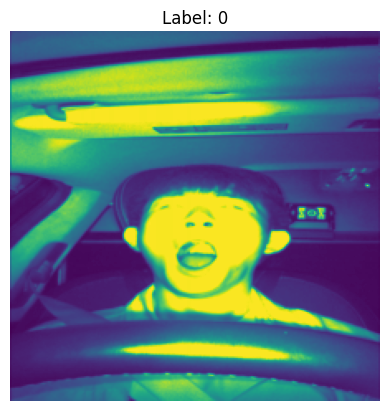

In [ ]:
import matplotlib.pyplot as plt

sample_data, sample_label = reduced_dataset[0]

# 샘플 데이터의 형상 출력
print(f"Sample data shape: {sample_data.shape}")

# 이미지 시각화 함수 정의
def show_image(tensor_image, label):
    # 텐서 이미지를 넘파이 배열로 변환
    image = tensor_image.numpy().squeeze()

    # 이미지 표시
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# 첫 번째 샘플 이미지 시각화
show_image(sample_data, sample_label)

######################
sample_data, sample_label = reduced_dataset[3]

# 샘플 데이터의 형상 출력
print(f"Sample data shape: {sample_data.shape}")

# 이미지 시각화 함수 정의
def show_image(tensor_image, label):
    # 텐서 이미지를 넘파이 배열로 변환
    image = tensor_image.numpy().squeeze()

    # 이미지 표시
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# 첫 번째 샘플 이미지 시각화
show_image(sample_data, sample_label)

In [ ]:
criterion = nn.CrossEntropyLoss()

def test(model):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).long().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Average loss: {:.4f}, Accuracy: {}/{}({:.2f}%)'.format(
         test_loss, correct, len(test_loader.dataset), accuracy))
    return test_loss, accuracy

test_loss, test_acc = test(myresnet50)
print(f"test : {test_acc}")

Average loss: 0.0311, Accuracy: 2295/2498(91.87%)
test : 91.87349879903923


In [ ]:
def virtual_test(model):
  model.eval()
  correct = 0

  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)

        output = model(data)

        #target 1차원으로 변환
        target_flattened = target.view(-1)
        target_counts = torch.bincount(target_flattened)

        target_most_common = torch.argmax(target_counts).item()


        pred = output.argmax(dim=1, keepdim=True)

        pred_flattened = pred.view(-1)
        pred_counts = torch.bincount(pred_flattened)

        pred_most_common = torch.argmax(pred_counts).item()

        if pred_most_common == target_most_common:
          correct += 1

  accuracy = 100. * correct / len(test_loader)

  print('\nvirtual_test: Accuracy: {}/{} ({:.6f}%)\n'.format(
        correct, len(test_loader),  accuracy))

In [ ]:
virtual_test(myresnet50)


virtual_test: Accuracy: 79/79 (100.000000%)



In [ ]:
test_loader = DataLoader(reduced_dataset, batch_size=32, shuffle=True, num_workers=8)

In [ ]:
def virtual_test(model):
  model.eval()
  correct = 0

  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)

        output = model(data)

        #target 1차원으로 변환
        target_flattened = target.view(-1)
        #print(target_flattened)

        #배치사이즈 크기안에서 인덱스가 몇번 나왔는지 반환
        #예시 [4, 2, 0, 1, 6, 1, 6, 1, 9, 2] -> 0번 레이블이 4번 나온거
        target_counts = torch.bincount(target_flattened)

        #가장 많이 나온 레이블을 반환
        #위 예시서 9번 나온 레이블 인덱스 -> 8을 반환 / 즉 8번 레이블이 가장 많이 나왔다는 의미
        target_most_common = torch.argmax(target_counts).item()

        # print(f'target 각 숫자의 발생 횟수: {target_counts}')
        # print(f'target 가장 많이 발생한 숫자: {target_most_common }')

        pred = output.argmax(dim=1, keepdim=True)

        pred_flattened = pred.view(-1)
        pred_counts = torch.bincount(pred_flattened)

        pred_most_common = torch.argmax(pred_counts).item()

        # print(f'pred 각 숫자의 발생 횟수: {pred_counts}')
        # print(f'pred 장 많이 발생한 숫자: {pred_most_common}')

        #pred과 target 각각에서 가장 많이 나온 인덱스가 같으면 정확도 올라감
        if pred_most_common == target_most_common:
          correct += 1
        #print(f'isSame: {same}')

  accuracy = 100. * correct / len(test_loader)

  print('\nvirtual_test: Accuracy: {}/{} ({:.6f}%)\n'.format(
        correct, len(test_loader),  accuracy))

In [ ]:
virtual_test(myresnet50)


virtual_test: Accuracy: 64/79 (81.012658%)



F1 Score: 0.9189
Confusion Matrix:
[[563   3   9   3   0]
 [  1 423   4   2   3]
 [  4   4 458  78   9]
 [  1   1  69 361   1]
 [  2   2   1   6 490]]


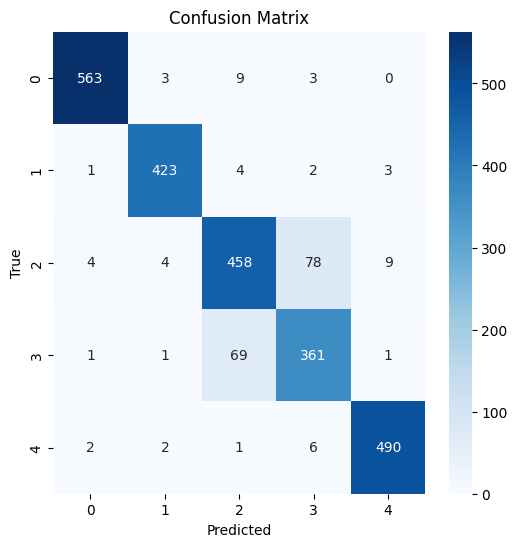

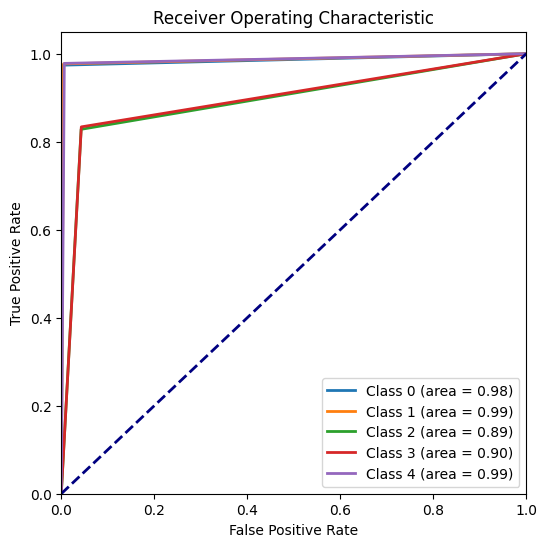

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 예측 함수
def get_predictions(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    return y_true, y_pred

# 평가 및 시각화 함수
def evaluate_and_plot(model, dataloader, device):
    y_true, y_pred = get_predictions(model, dataloader, device)

    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    print(f'F1 Score: {f1:.4f}')
    print(f'Confusion Matrix:\n{cm}')

    # Confusion Matrix plot
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve plot for each class
    plt.figure(figsize=(6, 6))
    n_classes = len(set(y_true))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve([1 if y == i else 0 for y in y_true], [1 if y == i else 0 for y in y_pred])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# 모델 평가 및 시각화
evaluate_and_plot(myresnet50, test_loader, device)
